In [3]:
import numpy as np
import matplotlib.pyplot as plt

We again reuse the code from last week's exercise:

In [4]:
def shift_right(spins: int, shift: int, N: int) -> int:
    for j in range(0,shift):
        spins = (spins>>1) + 2**(N-1)*(spins%2)
    return spins

def shift_left(spins:int, shift:int, N:int) -> int:
    for j in range(0, shift):
        if spins >= 2**(N-1):
            spins = (spins<<1) - (2**(N)) +1
        else:
            spins = spins<<1
    return spins

def count_upspins(i:int) -> int:
    return i.bit_count()

def spin_at_j(i: int, j: int) -> int:
    return (i>>j)%2

def flip_spin(i: int, j: int) -> int:
    return (1<<j)^i

def flip_all_spins(i: int, N: int) -> int:
    return i^(2**N-1)

Here we will work with the translational symmetry given by
$$
    T: |s_1,s_2,\ldots,s_N\rangle \rightarrow |s_N,s_1,\ldots,s_{N-1}\rangle
$$
For any spin configuration, this operator shifts all spins one position forward (recall that we assume periodic boundary conditions). This operator is a bit complicated in the sense that its orbits have different lengths and some orbits are incompatible with some eigenvalues.

The Hamiltonian commutes with the shift operator $T$. This can be utilized in order to decrease the Hilbert space size of the problem in the following way. For every state (bitstring) $|s\rangle$, define its _orbit_ as $O(|s\rangle) = \{T^n |s\rangle\}_n,$ e.g. the set of all possible unique bitstrings that can be constructed out of $|s\rangle$ by applying $T$ arbitrarily many times.

This defines an *equivalence relation*: all the bitstrings split into non-intersecting orbits (equivalence classes) $O_1, O_2, \ldots O_m$. Since $H$ and $T$ can be diagonalized simultaneously, let us fix some specific eigenvalue $z_k$ of $T$ and for each orbit $O_{\alpha}$ construct one $T$ eigenstate as
$$
|\chi_{k}^{\alpha}\rangle = \frac{1}{\sqrt{|O_{\alpha}|}} \sum\limits_{i = 0}^{|O_{\alpha}| - 1} z_k^{-i} T^i |\phi^{\alpha}\rangle.
$$

Here $|\phi^{\alpha}\rangle$ is the _orbit representative_ --- any priorly chosen state of the $O_{\alpha}$ orbit. It can be shown that the states $|\chi_{k}^{\alpha}\rangle$ united over all eigenvalues $z_k$ and orbits $\alpha$ form a new basis in the Hilbert space.

Finally, in this basis it can be shown that $\langle \chi^{k_1}_{\alpha}|H|\chi^{k_2}_{\beta}\rangle \propto \delta_{k_1 k_2}$: the Hamiltonian takes the _block-diagonal_ form, different eigenvalues do not mix (the Hamiltonian can only connect states with the same momentum eigenvalue) and the problem can be solved for every $z_k$ independently.

1. As a start, we will need the action of operator $T$ on index (it is convenient to define $T^n$ operator for arbitrary power $n$):

In [5]:
N = 8  # the number of spins in the system

def act_T(index: int, shift: int, num_spins: int) -> int:
    return shift_right(index, shift, num_spins)

#  check that T^N = E
for _ in range(100):
    a = np.random.randint(0, 1024)
    assert act_T(a, shift = 10, num_spins = 10) == a
print('All trials passed! You are perfect!')

All trials passed! You are perfect!


2. Now we need to define the lookup table: it maps each bitstring to the bitstring of its representative in the orbit. We will also need the list of unique representatives for each orbit. How to do this was already covered in last week's exercise:

In [6]:
# Get in the habit of using print statements
def orbit_representatives(num_spins: int) -> np.ndarray:
    representatives = []
    # |i> corresponds to a configuration
    for i in range(2 ** num_spins):
        i_shifts = [act_T(i, shift, num_spins) for shift in range(num_spins)]
        hits = [i_shift in representatives for i_shift in i_shifts]

        # Check if |j> := T^n|i> is already in the table for some n
        if np.any(hits):
            # If so use the state |j> as the representative
            representatives.append(i_shifts[np.where(hits)[0][0]])
        else:
            # Otherwise, use |i> as the representative
            representatives.append(i)

    return np.array(representatives)

representatives = orbit_representatives(N)  # in practice, one would find the representative "on the fly"
all_repr = np.unique(representatives)  # list of representatives

#  test that for every element table[i] in the table all its shifts have the same representative,
#  i.e. table[i] == table[shift(i)] for all shifts
for i in range(len(representatives)):
    representative = representatives[i]
    assert np.all(np.array([representatives[act_T(i, shift, N)] for shift in range(N)]) == representative)

Since $T^N = 1$, the possible eigenvalues are $$z_k = \exp\left(2 \pi i \frac{k}{N}\right).$$ Note that each orbit can have only specific eigenvalues, namely, we require that $$z_k^{|O_{\alpha}|} = 1,$$ which is quite obvious: if one shifted the state so many times that it comes into itself (length of the orbit $|O_{\alpha}|$), the amplitude should be the same.

Now we are ready to rewrite the Hamiltonian in the new basis of $|\chi_{k}^{\alpha}\rangle.$ Since the Hamiltonian has the block diagonal form in the $\chi$--basis, we will write a routine that will construct the block of a given eigenvalue $z_k$. The algorithm for this might be as follows: <br>
1) Loop over all orbits and find those that satisfy the $z_k^{|O|} = 1$ property. Write down the list of representatives. The length of this list would be the block dimension.<br>
2) Express the Hamiltonian in the $\chi$-basis. Luckily, we know the exact formula for every $|\chi_{k}^{\alpha}\rangle$ as the decomposition into bitstring basis states (see above). Let us consider explicitly the action of the Hamiltonian components <br>
2.a) The action of $H_J$ on the bitstring is trivial (diagonal). It leaves all bitstrings in their orbits, which means that $H_J$ does not mix different orbits and is diagonal in the $\chi$--basis:
\begin{gather} \langle \chi_{k}^{\alpha}|H_J| \chi_{k}^{\beta}\rangle = \delta_{\alpha \beta}\frac{1}{|O_{\alpha}|}\sum\limits_{j = 0}^{|O_{\alpha}| - 1} \langle T^{j} \phi^{\alpha} |H_J| T^{j} \phi^{\alpha}\rangle = \delta_{\alpha \beta} \langle \phi^{\alpha} |H_J| \phi^{\alpha}\rangle,\end{gather}
where we used $|z_k| = 1$ and the translational invariance of $H_J$.<br>
2.b) The $H_h = h \sum\limits_i \sigma^x_i$ field term flips spins and kicks a bitstring to another orbit. To write down its matrix elements, let us fix some specific spin $\sigma^x_{s}$. Then spins of the orbit $O_{\alpha}$ are mapped to some other orbits. For instance, $\sigma_s^x T^{j} |\phi^{\alpha}\rangle = T^{\zeta(j)} |\phi^{\gamma(j)}\rangle$. So, for every $j$ one has to define the resulting orbit index $\gamma(j)$ and the distance to the representative $\zeta(j)$. Then the matrix element reads <br>
    $$
        \langle \chi_{k}^{\beta}|\sigma^x_s|\chi_{k}^{\alpha}\rangle = \frac{1}{\sqrt{|O_{\alpha}| |O_{\beta}|}}\sum\limits_{j = 0}^{|O_{\alpha}| - 1} z_k^{\zeta(j) - j} \delta_{\beta \gamma(j)}.
    $$
    
Note that for any selected $s$ there will be projections onto orbitals that are not compatible with $z_k$. This is no surprise though: the Hamiltonian becomes translationally symmetric only after taking the sum over $s$. So, below we will neglect such contributions, but keeping in mind that they vanish only if the sum over $s$ is performed.

3. You already saw last week how to compute orbits that are compatible with a specific eigenvalue $z_k$:

In [7]:
def compatible_representatives(z_k: float, all_repr: list, representatives: np.ndarray) -> list:
    list_compatible_orbits = []

    for state in all_repr:
        orbit_length = np.sum(representatives == state)
        if np.isclose(z_k ** orbit_length, 1):
            list_compatible_orbits.append(state)
    return list_compatible_orbits

assert len(compatible_representatives(1.0, all_repr, representatives)) == len(all_repr)
#  sanity check that for $\lambda = 1$ any orbit goes

4. Check the resulting block dimensions and sum them to compare with the size of the full Hilbert space. What is the size of the largest block?

In [8]:
eigenvalues = [np.exp(1j * 2 * np.pi / N * k) for k in range(N)]

block_dim = np.zeros(N)
for i in range(N):
    orbits = compatible_representatives(eigenvalues[i], all_repr, representatives)
    block_dim[i] = len(orbits)


# Sanity check: \sum_{\lambda} (block dimension) = dimension of full Hilbert space
assert np.sum(block_dim) == 2 ** N
print("Dimension is consistent!")

print("Maximum block size: ", int(np.max(block_dim)), "; this corresponds to the eigenvalue", eigenvalues[np.where(np.max(block_dim))[0][0]])

Dimension is consistent!
Maximum block size:  36 ; this corresponds to the eigenvalue (1+0j)


<ipython-input-8-6027b32cd5d6>:13: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  print("Maximum block size: ", int(np.max(block_dim)), "; this corresponds to the eigenvalue", eigenvalues[np.where(np.max(block_dim))[0][0]])


Write the routine to calculate the diagonal part of $H^{\chi}$:

In [9]:
def H_J_chi(allowed_reprs: list, num_spins: int) -> np.ndarray:
    diag = []
    for c_alpha in allowed_reprs:
        num_opposite = count_upspins(c_alpha ^ shift_right(c_alpha, 1, num_spins))
        diag.append(num_opposite * (-1) + (num_spins - num_opposite) * (+1))
    return np.diag(diag)

And now the routine for the non-diagonal part (set $h^x = 1$):

In [10]:
def how_shifted(representative: int, state: int, num_spins: int) -> int:
    for i in range(num_spins):
        if state == act_T(representative, i, num_spins):
            return i
    assert False  # if called on states from different orbits

def H_h_chi(z_k: float, allowed_reprs: np.ndarray, representatives: np.ndarray, num_spins: int) -> np.ndarray:
    H_h = np.zeros((len(allowed_reprs), len(allowed_reprs)), dtype = np.complex128)

    for s in range(num_spins):  # which spin id we are flipping
        for index_alpha, phi_alpha in enumerate(allowed_reprs):
            N_alpha = np.sum(representatives == phi_alpha)

            for j in range(N_alpha):  # iterate over all states in this orbit
                # Compute sigma_s^x T^j|phi_alpha>.
                spin_alpha_j = act_T(phi_alpha, j, num_spins)
                spin_alpha_j_flipped = flip_spin(spin_alpha_j, s)

                # Find the representative |phi_gamma> of sigma_s^x T^j|phi_alpha>.
                phi_gamma = representatives[spin_alpha_j_flipped]  # find representative of image orbit
                if phi_gamma not in allowed_reprs:
                    continue  # actually, single \sigma_x can project onto "bad orbitals",
                              # but these projections vanish as we take sum over s

                # Find zeta such that T^zeta|phi_gamma> = sigma_s^x T^j|phi_alpha>.
                zeta = how_shifted(phi_gamma, spin_alpha_j_flipped, num_spins)  # zeta(j)

                index_gamma = np.where(allowed_reprs == phi_gamma)[0][0]
                N_gamma = np.sum(representatives == phi_gamma)

                # Compute the term in Eqn (5) and add it to H_h.
                H_h[index_alpha, index_gamma] += 1. / np.sqrt(N_alpha * N_gamma) * \
                    z_k ** (zeta - j)

    return H_h

5. Now let us plot the ground state in each $z_k$--segment. Note that the energy levels for $z_k$ and $z_k^*$ are degenerate, so we will only see $N / 2 + 1$ energy levels.

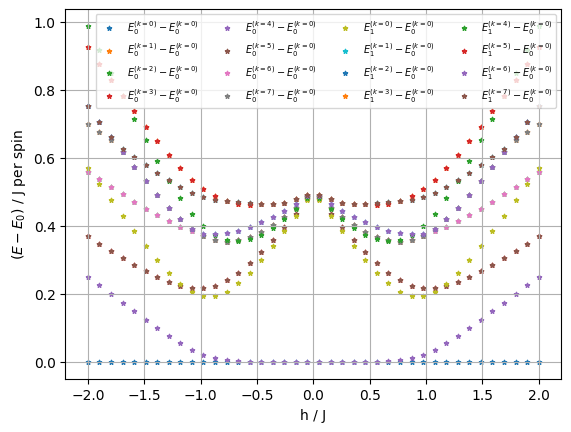

In [11]:
h_vals = np.linspace(-2, 2, 40)

levels_all = []
for k in np.arange(N):
    levels = []
    z_k = np.exp(2.0j * np.pi / N * k)
    allowed_reprs = compatible_representatives(z_k, all_repr, representatives)

    H_J_chibasis = H_J_chi(allowed_reprs, N)
    H_h_chibasis = H_h_chi(z_k, np.array(allowed_reprs), representatives, N)
    for h in h_vals:
        H_chibasis = H_J_chibasis + H_h_chibasis * h  # construct the total Hamiltonian
        assert np.allclose(H_chibasis, H_chibasis.conj().T)

        energies_h, _ = np.linalg.eigh(H_chibasis)
        levels.append(energies_h[:2])
    levels_all.append(np.array(levels))

k = 0
for levels in levels_all: # each element of levels_all corresponds to a value of k
    plt.scatter(h_vals, levels[:,0] / N - levels_all[0][:,0] / N, marker='*', s = 10.,label = '$E_0^{(k=%s)}-E_0^{(k=0)}$'%(k))
    k += 1

k = 0
for levels in levels_all: # each element of levels_all corresponds to a value of k
    plt.scatter(h_vals, levels[:,1] / N - levels_all[0][:,0] / N, marker='*', s = 10.,label = '$E_1^{(k=%s)}-E_0^{(k=0)}$'%(k))
    k += 1

plt.legend(ncols=4,fontsize = 7)
plt.grid(True)
plt.xlabel('h / J')
plt.ylabel('$(E - E_0)$ / J per spin')
plt.show()

What is it all necessary for? The splitting of the Hamiltonian into the subsectors allows us to save considerable computational effort for large systems. If the Hilbert space is divided roughly into $m$ sectors, construction of one sector Hamiltonian generates an overhead of order $O(N^2 / m)$ (we iterate over $N / m$ orbitals and consider in the worst case $O(N)$ terms in each). Mostly the existing algorithms for finding the ground state of $H$ do that through consecutive application of $H$ to the trial vector. The cost of this operation is reduced as $O(N^2 / m^2)$ and most importantly this operation is repeated thousands of times.

Another neat advantage of accounting for symmetries is that once you diagonalize the Hamiltonian in some specific sector, you immediately know its ground state properties (for instance, its momentum as in the case of $T$). Diagonalizing the Hamiltonian in the computational basis as a whole does not reflect the fact that the ground state properties can be quite subtle. For instance, in the region $|h| < 1$ the states $k = 0$ and $k = \pi$ are degenerate and one's ED solver can mix these solutions when diagonalizing the full Hamiltonian.